**Projeto de Transfer Learning - DIO**

**Aluno:** Cayo Silva

In [13]:
%matplotlib inline

import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

**Carregando as imagens**

In [14]:
root = 'Imagens'
train_split, val_split = 0.7, 0.15
exclude = ['.ipynb_checkpoints']

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['Imagens/Radish', 'Imagens/Carrot']


**Função que transforma imagens em um vetores**

In [15]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

**Carregando as imagens**

In [16]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

**Ordem aleatória dos dados**

In [17]:
random.shuffle(data)

**Treino / Validação / Teste**

In [18]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [19]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]


**Normalização dos Dados**

In [20]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(52, 2)


**Resumo dos dados**

In [21]:
# summary
print("Finalizado o carregamento de %d imagens com %d categorias"%(len(data), num_classes))
print("Treino / Validação / Teste: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("Formato dos dados de treino: ", x_train.shape)
print("Etiquetas dos dados: ", y_train.shape)


Finalizado o carregamento de 346 imagens com 2 categorias
Treino / Validação / Teste: 242, 52, 52
Formato dos dados de treino:  (242, 224, 224, 3)
Etiquetas dos dados:  (242, 2)


**Algumas imagens de exemplo**

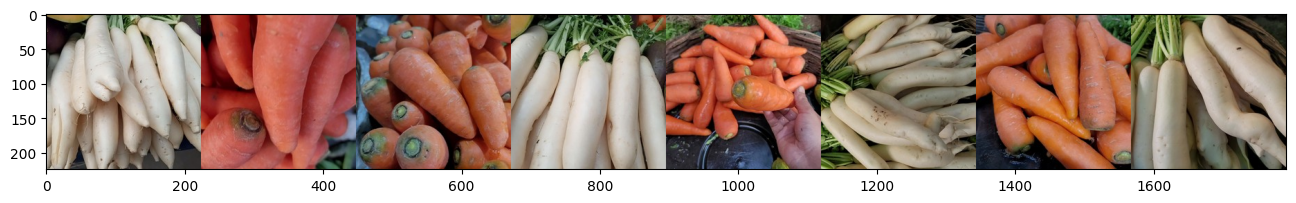

In [22]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

**Pegando um modelo treinado pela imagenet**

In [23]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


**Definindo os parâmetros do Modelo**

In [24]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [25]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

**Treinamento do modelo com as novas imagens**

In [26]:
# Rodando o Modelo com as novas imagens
history = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 181s 94s/step - accuracy: 0.5093 - loss: 0.9262 - val_accuracy: 0.6346 - val_loss: 0.9636
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 172s 103s/step - accuracy: 0.6001 - loss: 0.8976 - val_accuracy: 0.3654 - val_loss: 0.8517
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 190s 90s/step - accuracy: 0.3948 - loss: 0.8073 - val_accuracy: 0.7500 - val_loss: 0.5992
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 208s 92s/step - accuracy: 0.7183 - loss: 0.5615 - val_accuracy: 0.6346 - val_loss: 0.5503
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 196s 90s/step - accuracy: 0.5896 - loss: 0.6058 - val_accuracy: 0.7308 - val_loss: 0.4409
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 161s 91s/step - accuracy: 0.7607 - loss: 0.4430 - val_accuracy: 0.9231 - val_loss: 0.4483
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 180s 110s/step - accuracy: 0.9239 - loss: 0.4330 - val_accuracy: 0.8462 - val_loss: 0.4540
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 162s 90s/step - accuracy: 0.9166 - loss: 0.3969 - val_accuracy: 0.9231 - val_los

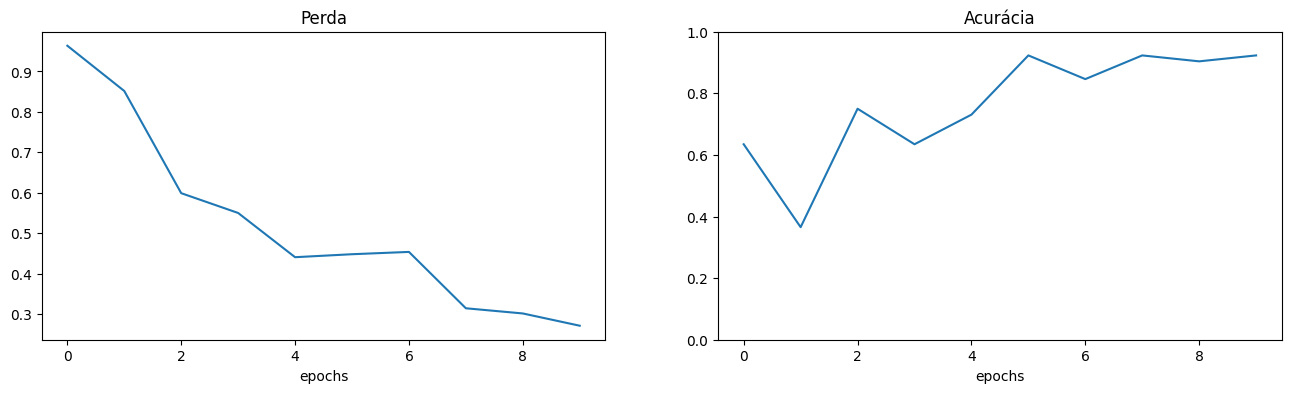

In [27]:
# Contruindo o gráfico de perda
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Perda")
ax.set_xlabel("epochs")

# Construindo o gráfico de acurácia
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Acurácia")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [28]:
# Calculo da perda e acurácia
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Perda Teste:', loss)
print('Acurácia Teste:', accuracy)

Perda Teste: 0.3286111056804657
Acurácia Teste: 0.9038461446762085


**Realizando a predição de uma imagem**

In [34]:
# Pegando a imagem selecionada e fazendo previsão da classe
img, x = get_image('Prever/exemplo3.jpg')
probabilities = model_new.predict([x])

# Identifica o índice da classe com a maior probabilidade
predicted_class = probabilities.argmax()

# Verifica qual classe foi prevista e exibe uma mensagem correspondente
if predicted_class == 0:
    print("A previsão foi para a primeira classe.")
elif predicted_class == 1:
    print("A previsão foi para a segunda classe.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
A previsão foi para a primeira classe.
